In [7]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..', '..')))
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from src.elements import (
    FEM_11, FEM_11_red, FEM_22,  
    FEM_21, 
    VEM_11, VEM_22,  VEM_21, 
)
from src.assembly import Timosheko_beam
from src.plotting import compute_w_φ_M_V_VM,compute_w_φ_M_V_VQ ,compute_w_φ_M_V_FL,compute_w_φ_M_V_FM,compute_w_φ_M_V_FQ 
from src.L2_norm import compute_L2_and_relative_errors_FL,compute_L2_and_relative_errors_FM,compute_L2_and_relative_errors_FQ,compute_L2_and_relative_errors_VM,compute_L2_and_relative_errors_VQ

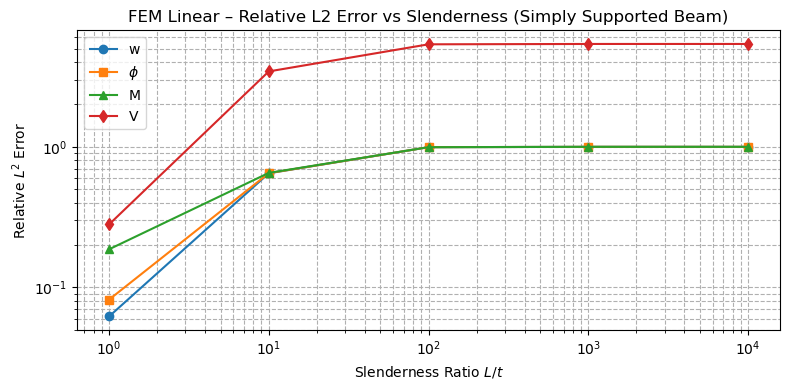

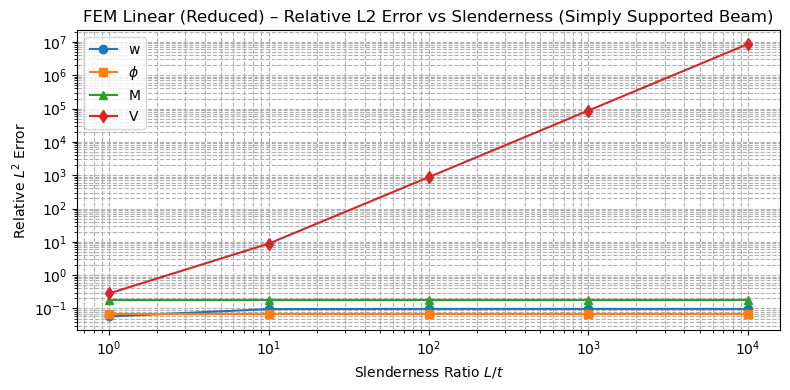

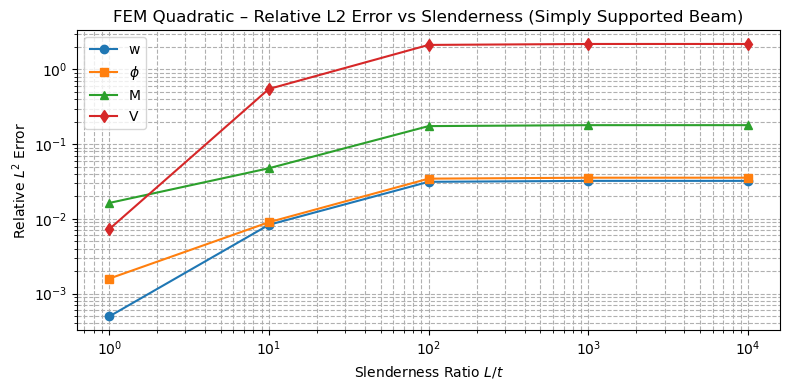

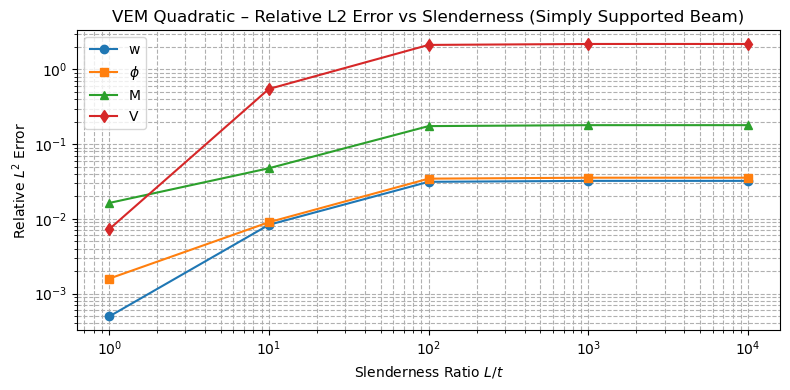

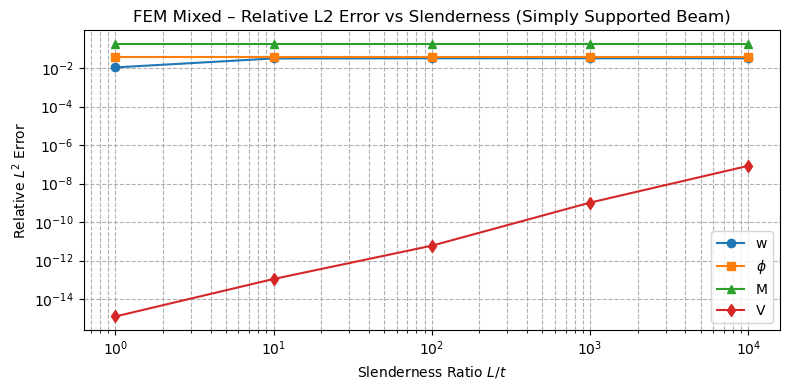

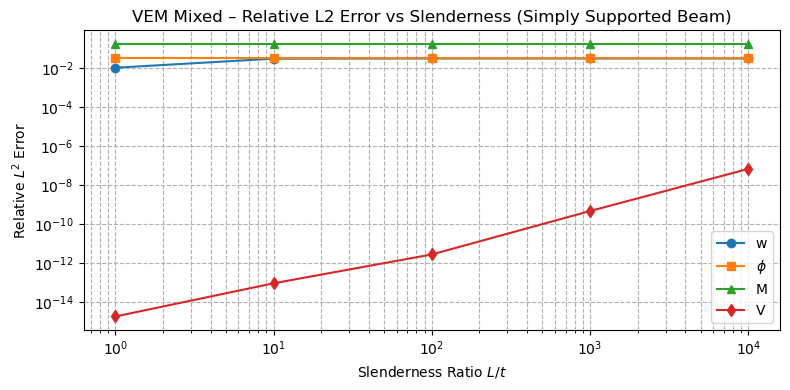

In [8]:
# Simply suported beam under uniform distributed load


# Slenderness study for all methods

# -----------------------------
# Problem parameters
# -----------------------------

L = 10.0
E = 10000
b = 1
nu = 0.0
alpha = 5/6
no_ele = 5
no_guass_point = 8 # for L2 error computation
# Slenderness ratios
L_over_t_values = np.array([ 1, 10, 100, 1000, 10000])
t_values = L / L_over_t_values


# -----------------------------
# Method definitions
# -----------------------------
methods = {
    "FEM Linear": {
        "FEM_type": FEM_11,
        "error_func": compute_L2_and_relative_errors_FL
    },
    "FEM Linear (Reduced)": {
        "FEM_type": FEM_11_red,
        "error_func": compute_L2_and_relative_errors_FL
    },
    "FEM Quadratic": {
        "FEM_type": FEM_22,
        "error_func": compute_L2_and_relative_errors_FQ
    }
    ,
    "VEM Quadratic": {
        "FEM_type": VEM_22,
        "error_func": compute_L2_and_relative_errors_VQ
    }
    ,
    "FEM Mixed": {
        "FEM_type": FEM_21,
        "error_func": compute_L2_and_relative_errors_FM
    },
    "VEM Mixed": {
        "FEM_type": VEM_21,
        "error_func": compute_L2_and_relative_errors_VM
    }
}

# -----------------------------
# Storage
# -----------------------------
errors = {
    name: {"w": [], "phi": [], "M": [], "V": []}
    for name in methods
}

# -----------------------------
# Main loop
# -----------------------------
for t in t_values:


 
    EI =  E*b*t**3/12
    G = E/(2*(1+nu))
    GA = alpha*G*b*t
    # uniform qistributed load
    q_e = -1.0*t**3
    m_e = 0.0


    dirichlet_bcs = [
        (0, 0.0),
        (-2, 0.0) 
    ]

    # 0,1 -> w1, theta (left hand)
    # -2,-1 -> w_end, theta_end (right hand)
    point_loads = [ 
            
            
    ]



    Boundary_parameter = [dirichlet_bcs , point_loads , q_e, m_e]
    def exact_solution_func(x):
        V   = q_e*(L/2-x) 
        M   = -q_e*x/2*(L-x)
        phi = -(q_e/2/EI)*(L*x**2/2 - x**3/3 - L**3/12) 
        w = -(1/EI)*(q_e/2*(L*x**3/6 - x**4/12 - L**3/12*x) )+ (1/GA)*(q_e*(L*x/2 - x**2/2) )
        

        return np.array([w, phi, M, V])
    
    for name, method in methods.items():

        U, _ = Timosheko_beam(
            [L, EI, GA, no_ele, method["FEM_type"]],
            Boundary_parameter
        )

        _,rel = method["error_func"](
            U,
            [L, EI, GA, no_ele, no_guass_point, exact_solution_func]
        )

        errors[name]["w"].append(rel[0])
        errors[name]["phi"].append(rel[1])
        errors[name]["M"].append(rel[2])
        errors[name]["V"].append(rel[3])


# -----------------------------
# Plotting
# -----------------------------
for name, err in errors.items():

    plt.figure(figsize=(8, 4))

    plt.loglog(L_over_t_values, err["w"],   '-o', label='w')
    plt.loglog(L_over_t_values, err["phi"], '-s', label=r'$\phi$')
    plt.loglog(L_over_t_values, err["M"],   '-^', label='M')
    plt.loglog(L_over_t_values, err["V"],   '-d', label='V')

    plt.xlabel("Slenderness Ratio $L/t$")
    plt.ylabel("Relative $L^2$ Error")
    plt.title(f"{name} – Relative L2 Error vs Slenderness (Simply Supported Beam)")
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.tight_layout()
    plt.show()
